In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

In [2]:
stack_data = pd.read_csv("stack-overflow-data.csv")

In [3]:
stack_data.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


In [4]:
stack_data['post'][0]

'what is causing this behavior  in our c# datetime type  <pre><code>[test] public void sadness() {    var datetime = datetime.utcnow;    assert.that(datetime  is.equalto(datetime.parse(datetime.tostring()))); } </code></pre>   failed :   <pre><code> expected: 2011-10-31 06:12:44.000  but was:  2011-10-31 06:12:44.350 </code></pre>   i wish to know what is happening behind the scenes in tostring() etc to cause this behavior.    edit after seeing jon s answer :   <pre><code>[test] public void newsadness() {     var datetime = datetime.utcnow;     assert.that(datetime  is.equalto(datetime.parse(datetime.tostring( o )))); } </code></pre>   result :   <pre><code>expected: 2011-10-31 12:03:04.161 but was:  2011-10-31 06:33:04.161 </code></pre>   same result with capital and small  o  . i m reading up the docs  but still unclear.'

In [5]:
stack_data['post'][1]

'have dynamic html load as if it was in an iframe  i have an asp.net 4.0 site. users can save an entire html page into the backend database. what i want to do is load the dynamic content into a div on an existing page in a content area and have a couple of things to happen:    i do not want any of the css to affect anything outside the div  when first trying this out loading of some badly formed html would move images and other divs outside the content area around.    a lot of these html pages use the  base  tag for images and links  i want the base tag respected inside the div.    i have a solution that i am going to try which is just to use an iframe and set its url to another child page that loads the dynamic html into its own page entirely. i am just wondering if there is a better solution.'

In [6]:
stack_data['post'][2]

'how to convert a float value in to min:sec  i m trying to convert my second in min:sec. my code is:    <pre><code>- (ibaction)calcola:(id)sender  {     float grandezzakb= [[fieldgrandezza text] floatvalue];     float velocitambps= [[fieldvelocita text] floatvalue] ;     float grandezzamb= grandezzakb*1000;     float velocitakb = velocitambps*128;     float seconditotali = grandezzamb/velocitakb;     float min = seconditotali / 60;      nsstring *risultato = [nsstring stringwithformat:@ %.02f minuti   min];      [labelrisultato settext:risultato]; } </code></pre>   sorry if it isn t english but i m italian :d someone can help me  i ve already tried with the mod but it doesn t work with float :( sorry if the code isn t perfect  but i m a newbie :)'

# Understanding The variables

In [7]:
stack_data.dtypes

post    object
tags    object
dtype: object

In [8]:
stack_data.shape

(40000, 2)

# Understanding Target Variables

In [9]:
stack_data['tags'].unique()

array(['c#', 'asp.net', 'objective-c', '.net', 'python', 'angularjs',
       'iphone', 'ruby-on-rails', 'ios', 'c', 'sql', 'java', 'jquery',
       'css', 'c++', 'php', 'android', 'mysql', 'javascript', 'html'],
      dtype=object)

# Checking for NULL values

In [10]:
stack_data.isnull().any()

post    False
tags    False
dtype: bool

# Countplot of Target Variable (Tags)

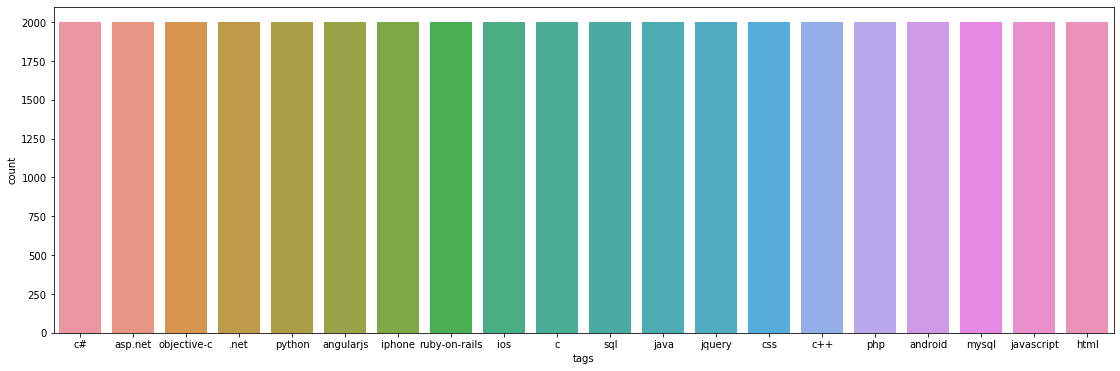

In [11]:
plt.figure(figsize=(19,6)) 
sns.countplot(stack_data.tags)
plt.show()

# Distribution Plot

In [12]:
stack_data['post_length'] = stack_data['post'].str.len()
stack_data['post_length']

0          833
1          804
2          755
3          349
4         1290
5          309
6          495
7          424
8         2022
9         1279
10         995
11         344
12         389
13        1338
14         349
15         228
16          62
17        2594
18         336
19        1037
20        2731
21         448
22        2620
23         517
24         544
25        2275
26         849
27         800
28         570
29        1207
         ...  
39970      303
39971      904
39972      525
39973      355
39974     1380
39975      316
39976      422
39977     1707
39978      517
39979     1333
39980      564
39981      387
39982      697
39983     1388
39984     2260
39985     1299
39986    13603
39987      286
39988      703
39989      612
39990     6514
39991      603
39992     1005
39993     1372
39994      530
39995     1004
39996      368
39997      793
39998     6339
39999     6153
Name: post_length, Length: 40000, dtype: int64

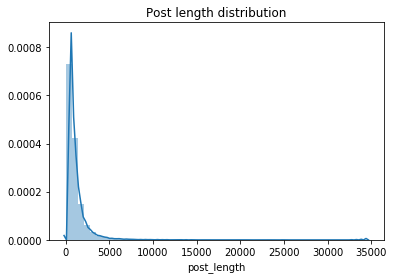

In [13]:
sns.distplot(stack_data['post_length']).set_title('Post length distribution');


# Feature Engineering

In [14]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def process_text(text):
    
    text = BeautifulSoup(text, "lxml").text 
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

In [15]:
stack_data['post_parsed'] = stack_data['post'].apply(process_text)

# Original Text

In [16]:
stack_data['post'][0]

'what is causing this behavior  in our c# datetime type  <pre><code>[test] public void sadness() {    var datetime = datetime.utcnow;    assert.that(datetime  is.equalto(datetime.parse(datetime.tostring()))); } </code></pre>   failed :   <pre><code> expected: 2011-10-31 06:12:44.000  but was:  2011-10-31 06:12:44.350 </code></pre>   i wish to know what is happening behind the scenes in tostring() etc to cause this behavior.    edit after seeing jon s answer :   <pre><code>[test] public void newsadness() {     var datetime = datetime.utcnow;     assert.that(datetime  is.equalto(datetime.parse(datetime.tostring( o )))); } </code></pre>   result :   <pre><code>expected: 2011-10-31 12:03:04.161 but was:  2011-10-31 06:33:04.161 </code></pre>   same result with capital and small  o  . i m reading up the docs  but still unclear.'

# Preprocessed Text

In [17]:
stack_data['post_parsed'][0]

'causing behavior c# datetime type test public void sadness var datetime datetimeutcnow assertthat datetime isequalto datetimeparse datetimetostring failed expected wish know happening behind scenes tostring etc cause behavior edit seeing jon answer test public void newsadness var datetime datetimeutcnow assertthat datetime isequalto datetimeparse datetimetostring result expected result capital small reading docs still unclear'

In [18]:
stack_data.head()

,post,tags,post_length,post_parsed
0,what is causing this behavior in our c# datet...,c#,833,causing behavior c# datetime type test public ...
1,have dynamic html load as if it was in an ifra...,asp.net,804,dynamic html load iframe aspnet site users sav...
2,how to convert a float value in to min:sec i ...,objective-c,755,convert float value minsec trying convert seco...
3,.net framework 4 redistributable just wonderi...,.net,349,net framework redistributable wondering get ne...
4,trying to calculate and print the mean and its...,python,1290,trying calculate print mean returning rather n...


# Label Encoding

In [19]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
stack_data['Tags_target']= label_encoder.fit_transform(stack_data['tags']) 

In [20]:
stack_data.Tags_target.unique()

array([ 5,  3, 15,  0, 17,  2, 10, 18,  9,  4, 19, 11, 13,  7,  6, 16,  1,
       14, 12,  8], dtype=int64)

In [21]:
stack_data.head()

,post,tags,post_length,post_parsed,Tags_target
0,what is causing this behavior in our c# datet...,c#,833,causing behavior c# datetime type test public ...,5
1,have dynamic html load as if it was in an ifra...,asp.net,804,dynamic html load iframe aspnet site users sav...,3
2,how to convert a float value in to min:sec i ...,objective-c,755,convert float value minsec trying convert seco...,15
3,.net framework 4 redistributable just wonderi...,.net,349,net framework redistributable wondering get ne...,0
4,trying to calculate and print the mean and its...,python,1290,trying calculate print mean returning rather n...,17


# Split the data in Training and testing

In [22]:
X_train, X_test, y_train, y_test = train_test_split(stack_data['post_parsed'], 
                                                    stack_data['Tags_target'], 
                                                    test_size=0.2, 
                                                    random_state=8)

In [23]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [24]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(32000, 300)
(8000, 300)


# Building Models

In [25]:
from sklearn.ensemble import RandomForestClassifier
model  = RandomForestClassifier()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.74175
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       374
           1       0.89      0.75      0.81       388
           2       0.89      0.82      0.85       402
           3       0.73      0.70      0.72       373
           4       0.73      0.80      0.76       399
           5       0.48      0.57      0.52       421
           6       0.71      0.62      0.66       402
           7       0.78      0.87      0.82       402
           8       0.68      0.63      0.66       399
           9       0.61      0.62      0.61       401
          10       0.60      0.59      0.60       393
          11       0.87      0.74      0.80       413
          12       0.78      0.79      0.79       394
          13       0.85      0.87      0.86       432
          14       0.88      0.78      0.82       397
          15       0.51      0.54      0.53       421
          16       0.86      0.83      0.84       397
        

In [26]:
model = LogisticRegression()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.74925
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       374
           1       0.87      0.76      0.81       388
           2       0.89      0.81      0.85       402
           3       0.74      0.72      0.73       373
           4       0.76      0.79      0.77       399
           5       0.48      0.58      0.53       421
           6       0.71      0.65      0.68       402
           7       0.80      0.87      0.83       402
           8       0.68      0.70      0.69       399
           9       0.62      0.60      0.61       401
          10       0.59      0.59      0.59       393
          11       0.86      0.73      0.79       413
          12       0.82      0.80      0.81       394
          13       0.86      0.88      0.86       432
          14       0.87      0.78      0.82       397
          15       0.52      0.53      0.53       421
          16       0.85      0.82      0.84       397
        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
model = KNeighborsClassifier()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.49725
              precision    recall  f1-score   support

           0       0.17      0.66      0.28       374
           1       0.67      0.54      0.60       388
           2       0.72      0.46      0.56       402
           3       0.63      0.45      0.52       373
           4       0.66      0.66      0.66       399
           5       0.44      0.24      0.31       421
           6       0.62      0.49      0.55       402
           7       0.67      0.69      0.68       402
           8       0.51      0.36      0.42       399
           9       0.57      0.36      0.44       401
          10       0.56      0.46      0.51       393
          11       0.20      0.69      0.31       413
          12       0.70      0.42      0.52       394
          13       0.71      0.44      0.54       432
          14       0.74      0.62      0.68       397
          15       0.56      0.27      0.36       421
          16       0.79      0.43      0.56       397
        

In [28]:
model = DecisionTreeClassifier()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.6505
              precision    recall  f1-score   support

           0       0.48      0.57      0.53       374
           1       0.76      0.72      0.74       388
           2       0.78      0.76      0.77       402
           3       0.58      0.60      0.59       373
           4       0.68      0.67      0.67       399
           5       0.40      0.36      0.38       421
           6       0.51      0.53      0.52       402
           7       0.75      0.73      0.74       402
           8       0.53      0.54      0.54       399
           9       0.52      0.52      0.52       401
          10       0.49      0.52      0.50       393
          11       0.76      0.71      0.73       413
          12       0.67      0.67      0.67       394
          13       0.77      0.75      0.76       432
          14       0.77      0.76      0.77       397
          15       0.41      0.38      0.39       421
          16       0.73      0.73      0.73       397
         

In [29]:
model = GaussianNB()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.50125
              precision    recall  f1-score   support

           0       0.66      0.39      0.49       374
           1       0.72      0.60      0.66       388
           2       0.72      0.72      0.72       402
           3       0.72      0.41      0.52       373
           4       0.41      0.90      0.57       399
           5       0.38      0.14      0.21       421
           6       0.44      0.51      0.47       402
           7       0.42      0.91      0.57       402
           8       0.47      0.05      0.09       399
           9       0.27      0.04      0.08       401
          10       0.25      0.76      0.38       393
          11       0.88      0.44      0.59       413
          12       0.59      0.22      0.32       394
          13       0.49      0.55      0.52       432
          14       0.44      0.16      0.23       397
          15       0.42      0.40      0.41       421
          16       0.85      0.34      0.48       397
        

In [31]:
stack = pd.DataFrame()

In [32]:
stack['post'] = stack_data['post_parsed']

In [33]:
stack['tags'] = stack_data['Tags_target']

In [34]:
stack.head()

,post,tags
0,causing behavior c# datetime type test public ...,5
1,dynamic html load iframe aspnet site users sav...,3
2,convert float value minsec trying convert seco...,15
3,net framework redistributable wondering get ne...,0
4,trying calculate print mean returning rather n...,17


In [38]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []

    
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    
    return labeled


X_train, X_test, y_train, y_test = train_test_split(stack.post, stack.tags, random_state=0, test_size=0.3)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [39]:
all_data[:2]

[TaggedDocument(words=['fulltext', 'search', 'php', 'pdo', 'returning', 'result', 'searched', 'lot', 'matter', 'find', 'wrong', 'setup', 'trying', 'fulltext', 'search', 'using', 'pdo', 'php', 'get', 'results', 'error', 'messages', 'table', 'contains', 'customer', 'details', 'id', 'int', 'auto_increment', 'name', 'varchar', 'lastname', 'varchar', 'company', 'varchar', 'adress', 'varchar', 'postcode', 'int', 'city', 'varchar', 'email', 'varchar', 'phone', 'varchar', 'orgnr', 'varchar', 'timestamp', 'timestamp', 'current_timestamp', 'run', 'sqlquery', 'alter', 'table', 'system_customer', 'add', 'fulltext', 'name', 'lastname', 'except', 'columns', 'id', 'postcode', 'timestamp', 'signs', 'trouble', 'far', 'idea', 'problem', 'lies', 'db', 'configuration', 'php', 'code', 'goes', 'php', 'sth', 'dbhprepare', 'select', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgnr', 'db_pre', 'customer', 'match', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgn

In [40]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 4449835.82it/s]


In [41]:
import numpy as np
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [42]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

accuracy 0.8051666666666667
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       589
           1       0.90      0.91      0.90       661
           2       0.95      0.93      0.94       606
           3       0.79      0.79      0.79       613
           4       0.85      0.90      0.87       601
           5       0.71      0.69      0.70       585
           6       0.87      0.81      0.84       621
           7       0.81      0.83      0.82       587
           8       0.67      0.67      0.67       560
           9       0.69      0.66      0.68       611
          10       0.68      0.67      0.68       593
          11       0.79      0.86      0.83       581
          12       0.80      0.74      0.77       608
          13       0.84      0.84      0.84       593
          14       0.85      0.81      0.83       592
          15       0.71      0.69      0.70       597
          16       0.84      0.86      0.85       604

In [43]:
model = RandomForestClassifier()
model = model.fit(train_vectors_dbow, y_train)
y_pred = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5880833333333333
              precision    recall  f1-score   support

           0       0.43      0.51      0.46       589
           1       0.74      0.71      0.72       661
           2       0.72      0.80      0.76       606
           3       0.56      0.54      0.55       613
           4       0.61      0.78      0.69       601
           5       0.43      0.36      0.39       585
           6       0.63      0.50      0.56       621
           7       0.60      0.84      0.70       587
           8       0.46      0.42      0.44       560
           9       0.44      0.44      0.44       611
          10       0.45      0.50      0.47       593
          11       0.61      0.55      0.58       581
          12       0.56      0.40      0.46       608
          13       0.61      0.59      0.60       593
          14       0.57      0.63      0.60       592
          15       0.50      0.44      0.47       597
          16       0.71      0.55      0.62       604

In [44]:
model = DecisionTreeClassifier()
model = model.fit(train_vectors_dbow, y_train)
y_pred = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.20225
              precision    recall  f1-score   support

           0       0.16      0.18      0.17       589
           1       0.24      0.21      0.22       661
           2       0.23      0.21      0.22       606
           3       0.22      0.21      0.22       613
           4       0.24      0.25      0.25       601
           5       0.13      0.14      0.14       585
           6       0.24      0.20      0.22       621
           7       0.29      0.29      0.29       587
           8       0.12      0.14      0.13       560
           9       0.20      0.21      0.21       611
          10       0.21      0.21      0.21       593
          11       0.15      0.15      0.15       581
          12       0.15      0.16      0.15       608
          13       0.18      0.18      0.18       593
          14       0.25      0.26      0.25       592
          15       0.18      0.19      0.19       597
          16       0.17      0.18      0.18       604
          

In [45]:
model = GaussianNB()
model = model.fit(train_vectors_dbow, y_train)
y_pred = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7145
              precision    recall  f1-score   support

           0       0.41      0.68      0.51       589
           1       0.94      0.70      0.80       661
           2       0.91      0.87      0.89       606
           3       0.80      0.60      0.68       613
           4       0.82      0.83      0.83       601
           5       0.63      0.60      0.61       585
           6       0.79      0.73      0.76       621
           7       0.79      0.82      0.80       587
           8       0.58      0.64      0.61       560
           9       0.57      0.41      0.48       611
          10       0.36      0.61      0.45       593
          11       0.84      0.71      0.77       581
          12       0.78      0.66      0.72       608
          13       0.80      0.74      0.77       593
          14       0.76      0.73      0.75       592
          15       0.64      0.62      0.63       597
          16       0.85      0.82      0.83       604
          1

In [46]:
model = KNeighborsClassifier()
model = model.fit(train_vectors_dbow, y_train)
y_pred = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5023333333333333
              precision    recall  f1-score   support

           0       0.22      0.82      0.35       589
           1       0.71      0.67      0.69       661
           2       0.90      0.43      0.58       606
           3       0.43      0.47      0.45       613
           4       0.65      0.72      0.69       601
           5       0.42      0.29      0.35       585
           6       0.74      0.35      0.48       621
           7       0.65      0.78      0.71       587
           8       0.39      0.47      0.43       560
           9       0.54      0.24      0.33       611
          10       0.31      0.72      0.44       593
          11       0.60      0.34      0.43       581
          12       0.60      0.26      0.37       608
          13       0.71      0.33      0.45       593
          14       0.70      0.43      0.53       592
          15       0.39      0.46      0.42       597
          16       0.85      0.34      0.49       604